# Segmentación de rutas logísticas

Cargar datos

In [16]:
# Imports y configuración
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

sns.set(style='whitegrid')
print('Imports cargados')

# Cargar datos y vista rápida
df = pd.read_csv('rutas_kmeans.csv')
df.head()

df.info()

df.describe().T



Imports cargados
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distancia_km    1800 non-null   float64
 1   duracion_horas  1800 non-null   float64
 2   coste           1800 non-null   float64
 3   num_paradas     1800 non-null   int64  
 4   carga_kg        1800 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 70.4 KB


,count,mean,std,min,25%,50%,75%,max
distancia_km,1800.0,355.683470,192.175487,20.0,217.252667,349.330275,491.038322,990.973998
duracion_horas,1800.0,5.996074,2.791892,1.0,3.975766,5.994914,7.871344,15.815001
coste,1800.0,407.730074,199.173741,50.0,264.052667,406.612516,547.531942,1071.227473
num_paradas,1800.0,7.374444,4.059975,1.0,4.000000,7.000000,11.000000,14.000000
carga_kg,1800.0,5038.130016,2384.504552,500.0,3355.484051,4984.056208,6655.659236,12454.907805


EDA

<Figure size 1000x600 with 0 Axes>

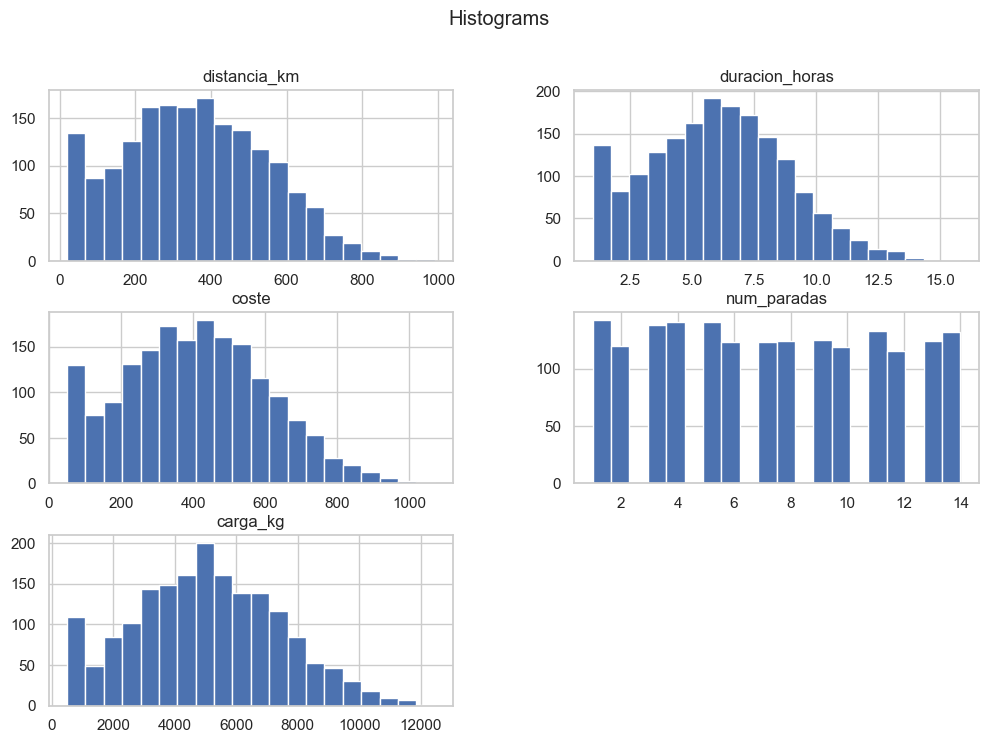

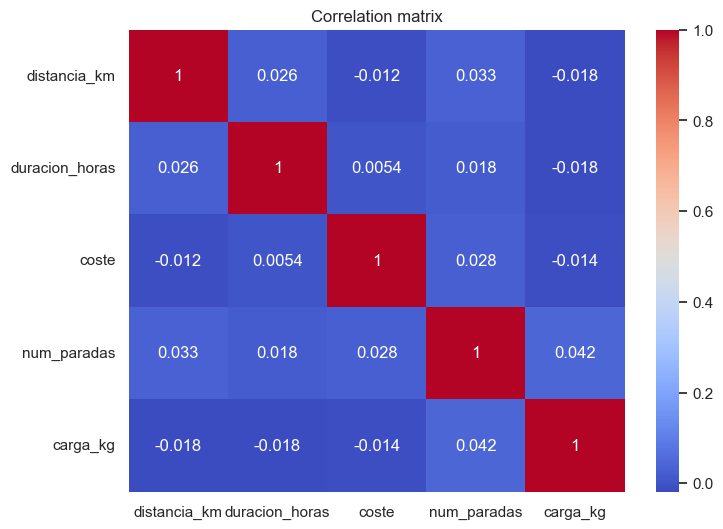

In [17]:
# Exploración rápida: distribuciones y correlación
plt.figure(figsize=(10,6))
df.hist(bins=20, figsize=(12,8))
plt.suptitle('Histograms')

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

Escalar

In [18]:
# Preprocesado: escalado
features = ['distancia_km','duracion_horas','coste','num_paradas','carga_kg']
X = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print('Shape scaled:', X_scaled.shape)

Shape scaled: (1800, 5)


Método del codo

Seleccionado best_k = 2


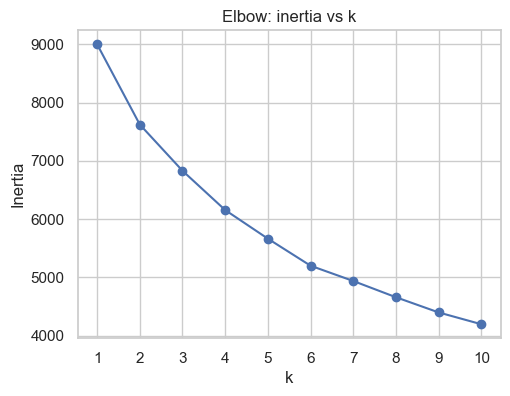

In [25]:
# Método del codo (inertia) y Silhouette para elegir k
inertia = []
silhs = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)
    try:
        sil = silhouette_score(X_scaled, km.labels_)
    except Exception:
        sil = np.nan
    silhs.append(sil)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K, inertia, '-o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow: inertia vs k')
plt.xticks(K)


# Elegir k según las gráficas (aquí usamos k=4 como ejemplo)
best_k = 2
print(f'Seleccionado best_k = {best_k}')


KMeans

In [22]:
# Ajustar KMeans final (elige k según las gráficas, aquí usamos k=4 como ejemplo)
best_k = 2
km_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = km_final.fit_predict(X_scaled)

df['cluster'] = labels

# Puntuación silhouette final
try:
    sil_final = silhouette_score(X_scaled, labels)
    print(f'Silhouette score (k={best_k}): {sil_final:.4f}')
except Exception:
    print('No se pudo calcular silhouette score para el modelo final')

# Centros en escala original
centers_orig = scaler.inverse_transform(km_final.cluster_centers_)
centers_df = pd.DataFrame(centers_orig, columns=features)
centers_df['cluster'] = centers_df.index

display(centers_df)

# Resumen por cluster
cluster_summary = df.groupby('cluster')[features].agg(['count','mean','std'])
cluster_summary

Silhouette score (k=2): 0.1544


,distancia_km,duracion_horas,coste,num_paradas,carga_kg,cluster
0,338.078039,5.810809,398.344259,4.019190,4871.196040,0
1,374.841120,6.197674,417.943409,11.025522,5219.782069,1


distancia_km                         duracion_horas            \
               count        mean         std          count      mean   
cluster                                                                 
0                938  338.078039  191.616183            938  5.810809   
1                862  374.841120  191.057067            862  6.197674   

                  coste                         num_paradas             \
              std count        mean         std       count       mean   
cluster                                                                  
0        2.746381   938  398.344259  200.479630         938   4.019190   
1        2.828415   862  417.943409  197.352166         862  11.025522   

                  carga_kg                            
              std    count         mean          std  
cluster                                               
0        2.059327      938  4871.196040  2365.971296  
1        2.053138      862  5219.782069  2392.672987

Interpretación

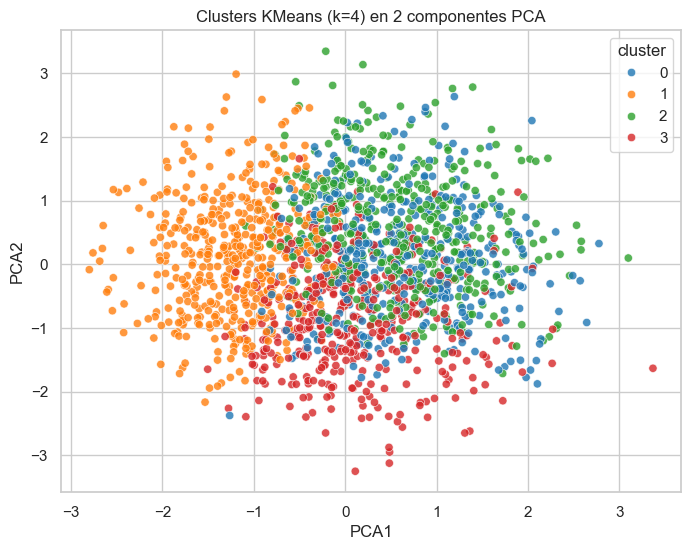

In [21]:
# Visualización 2D con PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['cluster'], palette='tab10', alpha=0.8)
plt.title(f'Clusters KMeans (k={best_k}) en 2 componentes PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='cluster')
plt.show()